# Deep Learning

En el workshop anterior trabajamos sobre el campo del Machine Learning de Reinforcement Learning, donde los modelos son desarrollados y entrenados para evaluar y tomar decisiones en entornos dinámicos. En este caso, el entrenamiento es llevado a cabo mediante _recompenzas_ ante aciertos y _castigos_ ante errores, no obstante esta no es la única forma de realizar el entrenamiento sobre un modelo de redes neuronales.

En el campo del Aprendizaje Supervizado, los modelos son entrenados para inferir y _aprender_ las _features_ y los patrones contenidos en una colección de datos para desempeñar alguna tarea de clasificación y/o regresión. En este caso, para entrenar los modelos es necesario contar con una serie de datos de entrada `X` con los resultados deseados de estos `Y`, también llamados datos de salida.

De este modo, a diferencia del Reinforcement Learning, en el Aprendizaje Supervizado los modelos _estudian_ estas series de datos ya conocidos para lograr abstraer y reconocer las características útiles para llevar a cabo la tarea objetivo. Todo esto por supuesto, de manera automática.

Para familiarizarnos con la implementación de estos modelos, en este workshop estudiaremos un caso sencillo de clasificación inspirado en el Playground de TensorFlow. En este caso, los puntos son segmentados o bien, etiquetados, en dos regiones dentro de los cuatro cuadrantes que se muestran en el diagrama a continuación. Así, el objetivo de nuestro modelo será clasificar la etiqueta de los puntos dentro de este espacio apartir del par de puntos $(x1, x2)$ como valores de entrada.


<img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/auxiliar_06/bin/problem_ref.png" height="280">

Para lograr esto, actualmente existen varios frameworks para desarrollar redes neuronales de Aprendizaje Profundo. No obstante, ahora nos concentraremos en la construcción e implementación de modelos de clasificación de deep learning mediante `TensorFlow`.


<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_02/bin/tensorflow.png" width="400">

`TensorFlow`, en términos generales, consiste en un framework diseñado para desarrollar e implementar algoritmos de Machine Learnine, y por supuesto, entre ellos, modelos de Deep Learning. Una de las particulares de este framework es que ofrece toda una gama de niveles de abstracción, desde el desarrollo de modelos de mayor complejidad mediante herramientas `low-level`, hasta la compilación y el entrenamiento de arquitecturas mediante estructuras `high-level`, como la API Keras.

Puede encontrar la documentación de estas librerías en los siguientes links:
- https://www.tensorflow.org/api_docs/python/
- https://keras.io/api/


In [12]:
!git clone https://github.com/cherrerab/roboticafcfm.git
%cd /content/roboticafcfm

Cloning into 'roboticafcfm'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 409 (delta 13), reused 0 (delta 0), pack-reused 362
Receiving objects: 100% (409/409), 14.27 MiB | 7.34 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/roboticafcfm


punto número: 100
X  [0.95603844 0.99948287]
Y  [0. 1.]


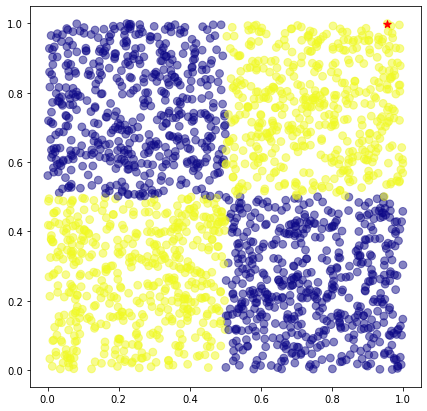

In [48]:
import numpy as np
import random
import matplotlib.pyplot as plt


# dataset size (cantidad de puntos)
N = 2000

# ---
# inicializar datasets
X = np.zeros( (N, 2) )
Y = np.zeros( (N, 2) )

for i in range(N):

  # generar datos (x1, x2) de manera random dentro de [0, 1]
  x1 = random.random()
  x2 = random.random()

  # guardar en el set X
  X[i, 0] = x1
  X[i, 1] = x2

  # obtener etiqueta del punto (x1, x2)
  y = (x1 - 0.5)*(x2 - 0.5)

  # etiqueta amarilla [0, 1]
  if y >= 0:
    Y[i, 0] = 0
    Y[i, 1] = 1

  # etiqueta azul [1, 0]
  else:
    Y[i, 0] = 1
    Y[i, 1] = 0

# ---
# print muestra del dataset
print('punto número: 100')
print('X ', X[100, :])
print('Y ', Y[100, :])

# ---
# visualizar datos en el plano
fig = plt.figure( figsize=(7, 7) )
plt.scatter(X[:,0], X[:,1], c=Y[:,1], alpha=0.5, s=60, cmap='plasma')
plt.scatter(X[100, 0], X[100, 1], c='r', marker='*', s=60)



## Data Splitting

Teniendo ya el dataset para el entrenamiento de la red neuronal, se debe dividir este en dos sets: uno de entrenamiento (`training set`) y otro de testing (`testing set`). El primero es utilizado, como su nombre lo indica, en el entrenamiento de la red neuronal mientras que el segundo es utilizado para evaluar el desempeño del modelo ya entrenado. La metrica utilizada comúnmente para evaluar un clasificador es el `accuracy`, el cual cuantifica la cantidad de aciertos de clasificación respecto al total de muestras, en un determinado conjunto de evaluación.

De este modo, como la red es evaluada sobre datos que "nunca ha visto" durante el entrenamiento, el `accuracy` permite observar si la red ha logrado generalizar el problema o si se ha _overfitteado_ (aprenderse los datos de entrenamiento de "memoria").

El _data splitting_ se puede lograr con el siguiente código:

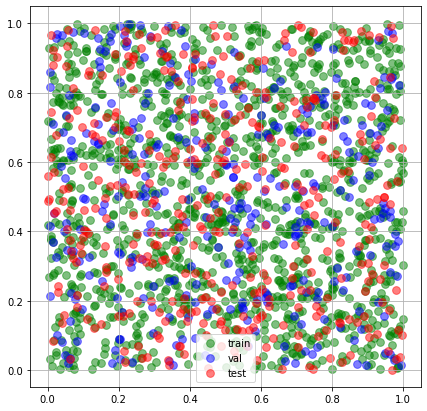

In [49]:
# importar librerías
from sklearn.model_selection import train_test_split

# ---
# generar sets de datos de training y testing
# la varibale test_size permite controlar la proporción entre los datos de testing y training.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,
                                                    random_state = 0)

# adicionalmente generaremos un conjunto de validación
# este conjunto será utilizado para monitorear la generalización del modelo
# sin utilizar el conjunto de testing.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,
                                                  random_state = 0)

# ---
# visualizar
plt.figure( figsize=(7, 7) )
plt.scatter(X_train[:,0], X_train[:,1], c='g', alpha=0.5, s=60, label='train')
plt.scatter(X_val[:,0], X_val[:,1], c='b', alpha=0.5, s=60, label='val')
plt.scatter(X_test[:,0], X_test[:,1], c='r', alpha=0.5, s=60, label='test')
plt.grid()
plt.legend()


# Model Building

Con los sets de entrenamiento y testing listos se puede dar paso a la configuración y entrenamiento de nuestra red neuronal. Para esto se utilizará principalmente la librería `keras` o `tf.keras`. Keras es una API de alto nivel para la creación y el entrenamiento de modelos de deep learning. Está orientada y diseñada para la construcción de modelos de forma modular o en bloques. De este modo, ofrece un framework mucho más amigable e intuitivo para principiantes, a la vez que mantiene un estructura personalizable y versátil que permite a usuarios más avanzados incorporar nuevas ideas.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_02/bin/keras_logo.png" width="400">


En este caso, se configurará una red Dense que consiste básicamente en capas de nodos que se van ordenando a medida que se agregan a la red.

La primera capa debe corresponderse con las variables de inputs con las que se alimenta a la red y por tanto ha de tener dos nodos, uno para cada variable x1 y x2.

Por otro lado, la última capa ha de tener dos nodos cuyo valor (output) debe corresponder a la etiqueta del punto (x1, x2). Como este valor solo puede ser 1 o 0, la función de activación de este nodo debe ser softmax (similar a la función de escalón unitario).

A continuación se presenta el código necesario para configurar una red simple de este tipo (Dense).

## Model Setup
Los elemenos básicos para la construcción de un modelo o `keras.Model` consisten en las capas o `layers` del modelo. En este sentido, configurar un modelo en Keras resulta en ir uniendo o conectando capas `keras.layers` de manera secuencial.

Para comenzar e introducir el framework de esta librería, construiremos un modelo o red neuronal `Sequential` a partir de únicamente capas `keras.layers.Dense` y otras capas elementales.
- https://keras.io/api/layers/
- https://keras.io/api/layers/activations/

De esta forma, en términos generales, compondremos nuestro modelo de una serie de capas `Dense`, que se encargarán de procesar la información y los patrones de los datos de entrada hasta una última capa `Dense` con únicamente 2 nodos que determinarán las etiquetas de los puntos $(x_1, x_2)$ que se ingresen al modelo.

<img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/auxiliar_06/bin/model_ref.png" height="200">

In [50]:
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense

# inicializar modelo keras.Sequential
model = Sequential()

# ahora podemos ir agregando secuencialmente capas nuestro modelo
# mediante el método keras.Model.add

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
input_dim = ( 2, )
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Dense.
# https://keras.io/api/layers/core_layers/dense/

# las keras.layers.Dense reciben la cantidad de nodos o units dentro
# de la capa y la función de activación que operarán.
# https://keras.io/api/layers/activations/
model.add( Dense( units=128, activation='relu' ) )
model.add( Dense( units=256, activation='relu' ) )
model.add( Dense( units=256, activation='relu' ) )

# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas o estados de salud.
labels_num = 2
model.add( Dense(units=labels_num, activation='softmax') )

Así, hemos construido nuestro modelo de clasificación el cual consiste de una capa de entrada `Input`, tres capas ocultas Fully Connected o `Dense` con 64 nodos de activación ReLU cada una, y una capa de salida `Dense` de 2 nodos con función de activación `softmax`. De esta manera, cada uno de los nodos de salida estará asociado a una de las etiquetas en el problema.

Para imprimir información sobre el modelo generado, Keras cuenta con el método `keras.Model.summary` para presentar un resumen de la arquitectura de la red neuronal.


In [51]:
# imprimir object o clase del modelo
print('type(model): ', type(model))

# imprimir resumen del modelo
print('\nclassification model summary:\n')
model.summary()

type(model):  <class 'tensorflow.python.keras.engine.sequential.Sequential'>

classification model summary:

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 514       
Total params: 99,714
Trainable params: 99,714
Non-trainable params: 0
_________________________________________________________________


## Compile Model
Antes de poner a entrenar al modelo, es necesario realizar unas configuraciones adicionales. En particular, debemos especificar la función de pérdida o `loss function` que se optimizará durante el entrenamiento y el método de optimización como SGD o Adam.
- https://keras.io/api/models/model_training_apis/
- https://keras.io/api/optimizers/

In [52]:
from keras.optimizers import Adam

# configurar optimizador Adam
# https://keras.io/api/optimizers/adam/
opt = Adam(learning_rate=1e-3)

# ---
# compilar modelo siguiendo como función de pérdida
# la categorical crossentropy
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Model Training
Hemos llegado a la parte final del proceso, para entrenar nuestro modelo debemos especificar los sets que utilizaremos para el proceso `(X_train, Y_train)`, la cantidad de `epochs` que durará el entrenamiento, y el `batch size` de muestras que se irán entregando al modelo a medida que este va iterativamente ajustando sus parámetros.

Para entrenar `keras.Models` se utiliza el método `keras.Model.fit`, el cual aparte de iniciar y realizar la rutina de entrenamiento, retorna un registro `History`. Mediante `History.history` es posible acceder a la evolución de la función de pérdida durante el entrenamiento tanto sobre los datos de `train` como sobre los de `validation`.

Epoch 1/160
36/36 [==============================] - 0s 6ms/step - loss: 0.5815 - accuracy: 0.7398 - val_loss: 0.4605 - val_accuracy: 0.7969
Epoch 2/160
36/36 [==============================] - 0s 3ms/step - loss: 0.3696 - accuracy: 0.8422 - val_loss: 0.3846 - val_accuracy: 0.8062
Epoch 3/160
36/36 [==============================] - 0s 3ms/step - loss: 0.3183 - accuracy: 0.8586 - val_loss: 0.4356 - val_accuracy: 0.8156
Epoch 4/160
36/36 [==============================] - 0s 3ms/step - loss: 0.2862 - accuracy: 0.8820 - val_loss: 0.2788 - val_accuracy: 0.8719
Epoch 5/160
36/36 [==============================] - 0s 3ms/step - loss: 0.2403 - accuracy: 0.8945 - val_loss: 0.2251 - val_accuracy: 0.9000
Epoch 6/160
36/36 [==============================] - 0s 3ms/step - loss: 0.2035 - accuracy: 0.9156 - val_loss: 0.2153 - val_accuracy: 0.9156
Epoch 7/160
36/36 [==============================] - 0s 3ms/step - loss: 0.1648 - accuracy: 0.9266 - val_loss: 0.1552 - val_accuracy: 0.9469
Epoch 8/160
3

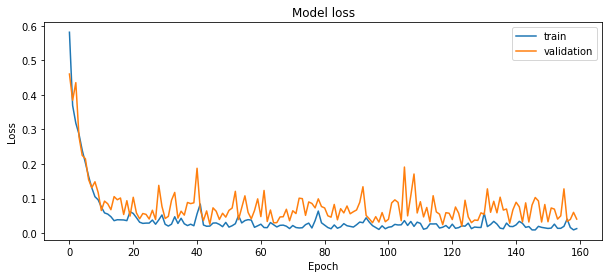

In [53]:
from utils import plot_loss_function

# realizar rutina de entrenamiento
train_history = model.fit(X_train, Y_train,
                          batch_size=36, epochs=160,
                          validation_data=(X_val, Y_val))

# plot gráfico de función de pérdida
plot_loss_function(train_history, figsize=(10,4))

## Model Evaluation
Finalmente, una vez entrenado nuestro modelo debemos evaluar su desempeño. En este caso particular, debemos usar los datos que aislamos para `testing` `(X_test, Y_test)`. Para utilizar el `keras.Model` sobre nuevos datos de clasificación, conviene utilizar el método `keras.Sequential.predict`.

testing accuracy: 0.983


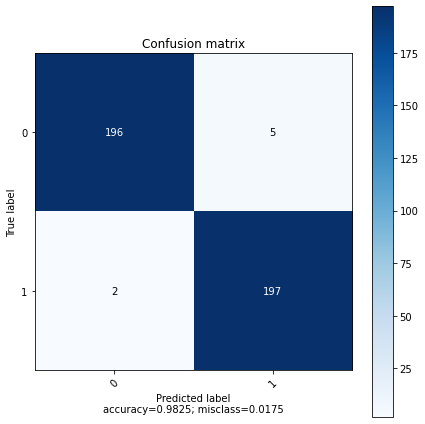

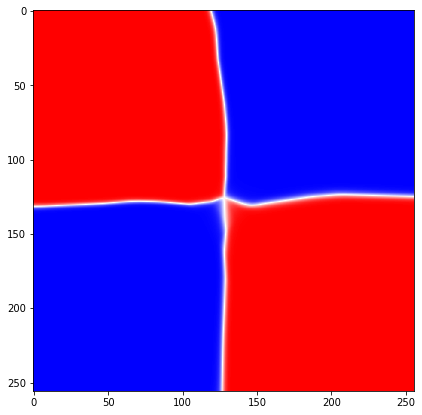

In [54]:
from sklearn.metrics import accuracy_score

from utils import plot_classification_map
from utils import plot_confusion_matrix

# obtener predicciones de X_test
Y_pred = model.predict(X_test)

# para que el resultado nos sea más intuitivo transformaremos
# las etiquetas nuevamente a non one-hot-encoding
# utilizando np.argmax
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# calcular accuracy de la clasificación.
accuracy = accuracy_score(Y_true, Y_pred)
print('testing accuracy: {:1.3f}'.format(accuracy))

# ---
# visualizar evaluación

# matriz de confusión
plot_confusion_matrix(Y_true, Y_pred,
                      target_names=['0', '1'], figsize=(6, 6))

# classification map
plot_classification_map(model, (0,1), (0,1), 256)
